###### Created by Peter Butcher for Confident Cannabis on 11/22/2017

Environment was setup using anaconda to create separate python environment for this project to reduce the chance of conflicts between python packages and multiple versions of python

Conda installed using python 2.7 for reasons unknown, could reinstall with python 3 if needed

##### Import packages

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

/Users/hannahobrien/anaconda3/envs/PAB_CCPrice/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Load train data

In [2]:
data_in = pd.read_csv('dataset.csv')
data_in = data_in.iloc[:, 2:] #Remove first column as has no info, and second column date as have numeric timestamp

##### Load test data

In [3]:
test_in = pd.read_csv('testset.csv')
test_in = test_in.iloc[:, 2:] #Remove first column as has no info, and second column date as have numeric timestamp

Unwanted columns have been removed from the data:
    
Retailer, Retailer city, processor, processor city, producer, producer city, strain display name, and product name

Month has been changed to a string

In [4]:
data_in['month']=data_in['month'].astype(str)
test_in['month']=test_in['month'].astype(str)

#### Exploratory data analysis

Check data for:

1) Missing values which need filling in with mean
- No apparent missing values

2) Categorical variables that need dummy variables
- See below

3) Skewed distribution of numeric values (log transform)
    
------------------------------------------------------------

Notes:

CBD column has lots of 0s. May need to do log1p regression

Columns to make dummy variables:


1) product_name

2) lab_name

3) Month


Columns to convert numeric to log:

1) retailer_to distances (9 total)

2) product_name

3) product_size

4) distance

5) total_lb_sold

6) units_sold

7) THC

8) cbd. be wary of 0s

9) moisture

10) pplb_pretax

Unsure:

1) date_sessiontime: converted

3) comp_1, comp_2, comp_3, comp_4 (not converted)

##### Explore skewness

In [5]:
numeric_feats = data_in.dtypes[data_in.dtypes != "object"].index
numeric_feats_skew = data_in[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
print(numeric_feats_skew)

date_sessiontime            -0.285427
retailer_to_seattle          1.245950
retailer_to_tacoma           1.312695
retailer_to_bellingham       1.094117
retailer_to_olympia          1.429420
retailer_to_bellingham.1     1.094117
retailer_to_vancouver        0.505978
retailer_to_kennewick       -0.896765
retailer_to_yakima          -0.437359
retailer_to_spokane         -1.518944
product_size_g               3.014995
distance                     1.070127
total_lb_sold                7.302633
units_sold                   7.043548
thc                         -0.706251
cbd                         10.928785
moisture                     0.259514
comp_1                      -0.047730
comp_2                       0.594879
comp_3                      -1.950353
comp_4                       2.483824
pplb_pretax                  0.454184
dtype: float64


Using threshold of 0.75 for skewness

In [6]:
skewed_numeric_feats = numeric_feats_skew[numeric_feats_skew > 0.75]
print(skewed_numeric_feats)

retailer_to_seattle          1.245950
retailer_to_tacoma           1.312695
retailer_to_bellingham       1.094117
retailer_to_olympia          1.429420
retailer_to_bellingham.1     1.094117
product_size_g               3.014995
distance                     1.070127
total_lb_sold                7.302633
units_sold                   7.043548
cbd                         10.928785
comp_4                       2.483824
dtype: float64


###### For now going to transform all numeric data using log1p. Later may want to be more specific for data type.

#### Feature engineering
Create dummy variables and transform/scale numeric data. All this needs to be done for test data. Takes a little while to run, may be a bottleneck.

Also, may run into problem with test data as will only have one producer. Might have to create empty dummy variables.

In [7]:
def create_dummies(data_in):
    cols2edit = [i for i in data_in.columns if type(data_in[i].iloc[1]) == str or type(data_in[i].iloc[1]) == float]
    for col_id in cols2edit:
        data_in[col_id].fillna('NULL', inplace = True) #if any nas are present, which there dont appear to be
        data_in = pd.concat((data_in,pd.get_dummies(data_in[col_id], prefix = col_id)), axis = 1) #create dummy variables
        del data_in[col_id]
    return data_in

Convert numeric to log: avoids bias towards fitting larger values. Using log1p as adds a 1 which is better for 0 values (really only present in CBD)

In [8]:
def transf_numeric(data_in):
    numeric_feats = data_in.dtypes[data_in.dtypes != "object"].index
    #Remove 4 comps as produce error
    rm_list = ['comp_1','comp_2','comp_3','comp_4']
    numeric_feats_conv = [i for i in numeric_feats if i not in rm_list]
    data_in[numeric_feats_conv] = np.log1p(data_in[numeric_feats_conv]) #using log1p on PCA data produces nan. Can convert to num with nan_to_num
    rm_list = ['pplb_pretax']
    numeric_feats= [i for i in numeric_feats if i not in rm_list]
    scaler = StandardScaler().fit(data_in[numeric_feats])
    data_in[numeric_feats] = scaler.transform(data_in[numeric_feats])
    return data_in

Could create preprocess function but each one takes a while to run: hard to tell if frozen

def preprocess_data(data_in):
    data_in=create_dummies(data_in)
    data_in=transf_numeric(data_in)
    return data_in

#### Preprocess data

In [9]:
data_in=create_dummies(data_in)

In [10]:
data_in=transf_numeric(data_in)

In [11]:
test_in=create_dummies(test_in)

In [12]:
test_in=transf_numeric(test_in)

#### Using full data set

In [13]:
pplb_train=data_in.pplb_pretax
data_train=data_in.drop('pplb_pretax', axis=1)
del data_in
pplb_test=test_in.pplb_pretax
data_test=test_in.drop('pplb_pretax', axis=1)
del test_in

#### Lasso Regression
Allows some parameters to dropout of model

In [14]:
alpha_ridge = [1e-5, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]

In [15]:
coeffs = {}
for alpha in alpha_ridge:
    r = Lasso(alpha=alpha, normalize=True, max_iter=100000000)
    r = r.fit(data_train, pplb_train)
    
grid_search = GridSearchCV(Lasso(alpha=alpha, normalize=True), scoring='neg_mean_squared_error',
                           param_grid={'alpha': alpha_ridge}, cv=10, n_jobs=-1)
grid_search.fit(data_train, pplb_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Lasso(alpha=20, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 1, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Print parameters

In [16]:
print (grid_search.score(data_train, pplb_train))

-0.039827384576


In [17]:
print (grid_search.best_estimator_)

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


Having identified our optimal alpha of 0.00001, visualize the root mean squared error of all the other alphas.

Text(0,0.5,u'rmse')

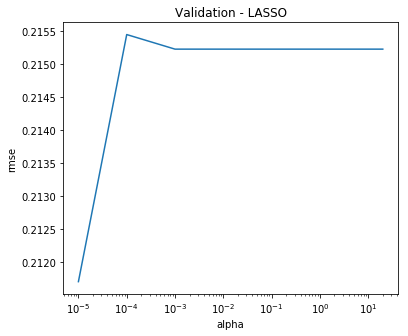

In [18]:
alpha = alpha_ridge
rmse = list(np.sqrt(-grid_search.cv_results_['mean_test_score']))

plt.figure(figsize=(6,5))
lasso_cv = pd.Series(rmse, index = alpha)
lasso_cv.plot(title = "Validation - LASSO", logx=True)
plt.xlabel("alpha")
plt.ylabel("rmse")

Fit model to training data

In [19]:
lasso = Lasso(alpha=.00001, normalize=True, max_iter=1e6)
lasso = lasso.fit(data_train, pplb_train)

How many variables has our model chosen?

In [20]:
coef = pd.Series(lasso.coef_, index = data_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 37 variables and eliminated the other 15 variables


In [21]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5,1,u'Coefficients in the Lasso Model')

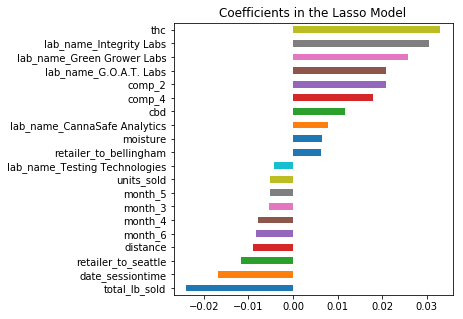

In [22]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

Predict the test data using the Lasso model

In [23]:
lasso_pred = lasso.predict(data_test) #Make predictions.

Compute MSE

In [24]:
print("LASSO score on test set in log format: ", mean_squared_error(pplb_test, lasso_pred))

('LASSO score on test set in log format: ', 0.040743536576879166)


In [25]:
print("LASSO score on test set in numeric format: ", mean_squared_error(np.expm1(pplb_test), np.expm1(lasso_pred)))

('LASSO score on test set in numeric format: ', 104509.15682364782)


###### Error is squared so it becomes large

#### XGBoost Model
Can take a while with large data set

In [26]:
regr = xgb.XGBRegressor(
                 colsample_bytree=0.3,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=1668,                                                                  
                 reg_alpha=1,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

Fit XGBR model

In [27]:
regr.fit(data_train, pplb_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.3,
       gamma=0.0, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=1.5, missing=None, n_estimators=1668, nthread=-1,
       objective='reg:linear', reg_alpha=1, reg_lambda=0.6,
       scale_pos_weight=1, seed=42, silent=1, subsample=0.2)

Run prediction on training set

In [28]:
XGBR_pred = regr.predict(data_test)
print("XGBoost score on test set in log format: ", mean_squared_error(pplb_test, XGBR_pred))

('XGBoost score on test set in log format: ', 0.031271195597012705)


In [29]:
XGBR_pred = regr.predict(data_test)
print("XGBoost score on test set in numeric format: ", mean_squared_error(np.expm1(pplb_test), np.expm1(XGBR_pred)))

('XGBoost score on test set in numeric format: ', 81560.819530139488)


#### Blending Model Results

In [30]:
train_predictions_blend = (.4*lasso_pred + .6*XGBR_pred)

In [31]:
print("Blended model score on test set in log format: ", mean_squared_error(pplb_test, train_predictions_blend))

('Blended model score on test set in log format: ', 0.033985616309264964)


In [32]:
print("Blended model score on test set in numeric format: ", mean_squared_error(np.expm1(pplb_test), np.expm1(train_predictions_blend)))

('Blended model score on test set in numeric format: ', 88286.311595523526)


##### Save predictions to CSV

In [36]:
np.savetxt("PAB_predictions.csv", np.expm1(train_predictions_blend), delimiter=",")

#### On XGBR model performs the best, including over blended model
Due to the opaque nature of the XGBoost model I am keeping the blended model